## Problem Description

Dataset is comprising of 27558 real images containing into train and test folder.

We are required to train model to predict if the model can distinguish between images of blood cells as infected and uninfected as accurately as possible.

The images are of different dimensions and colored

We will be exploring CNN model capabilities to perform the task

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = 'F:\\Python Directory\\cell_images'
os.listdir(data_dir)

['test', 'train']

In [3]:
test_path = data_dir+'\\test\\'
train_path = data_dir+'\\train\\'
print(os.listdir(train_path))
print(os.listdir(test_path))

['parasitized', 'uninfected']
['parasitized', 'uninfected']


Here in train and test folders, we have 2 more sub-directories: 'parasitized' and 'uninfected' referring to our class labels.

To understand the difference between an infected or an uninfected blood cell. Let's visualize the images from each of the class

In [4]:
os.listdir(train_path+'\\parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

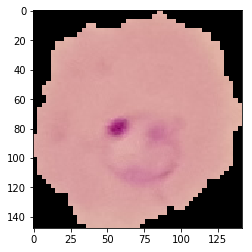

In [5]:
#infected cell
inf_img = os.listdir(train_path+'\\parasitized')[0]
inf_img = imread(train_path+'\\parasitized'+'\\'+inf_img)
plt.imshow(inf_img)

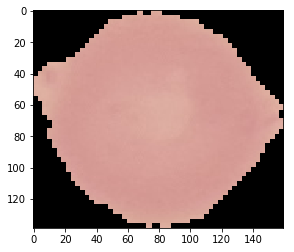

In [6]:
#uninfected cell
uninf_img = os.listdir(train_path+'\\uninfected')[0]
uninf_img = imread(train_path+'\\uninfected'+'\\'+uninf_img)
plt.imshow(uninf_img)

In [7]:
#let's print the dimensions of these 2 test images
print(inf_img.shape)
print(uninf_img.shape)

(148, 142, 3)
(139, 160, 3)


The printed dimensions clearly shows that these images are not of same dimensions which is a problem to our CNN model as we can't feed them with differing dimensions. We have to preprocess them to adjust the dimensionality to be equal.

Strategy:

We can check for average dimensions of all the images and unify the dimension [height, width] by replacing with average across all images. In this some images would be stretched up and some would be compressed.

In [8]:
dim1 = []
dim2 = []
for image_filename in os.listdir(train_path+'\\uninfected'):
    img = imread(train_path+'\\uninfected'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

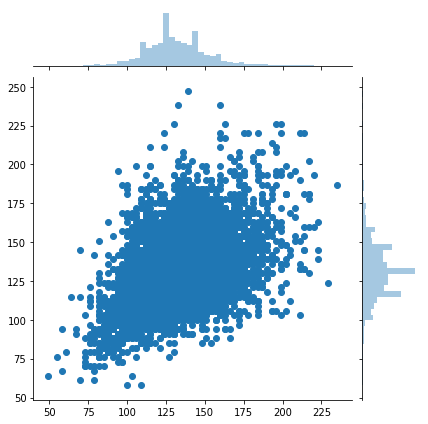

In [9]:
sns.jointplot(dim1,dim2)

In [10]:
print(np.mean(dim1))
print(np.mean(dim2))

131.64820899110507
131.4041990544114


Looking at the average of height and width of images, we can safely force images to be of size [130, 130, 3]

In [11]:
image_shape = (130,130,3)

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the ImageDataGenerator to do this automatically for us.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

Now we can check for the differences in image obtained after applying image augmentation

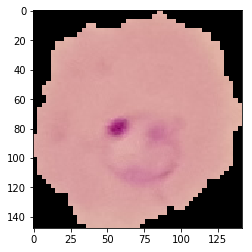

In [13]:
plt.imshow(inf_img)

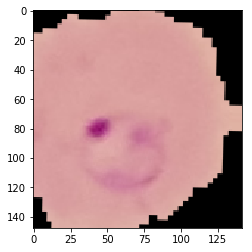

In [14]:
#image post augmentation applied
plt.imshow(image_gen.random_transform(inf_img))

In order to use .flow_from_directory, we need to organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

In [15]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [16]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


#### Define and Compile Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [18]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
# Here we say randomly turn off 50% of neurons adding Dropout.
model.add(Dropout(0.5))
# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [19]:
#apply early stopping criteria
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

#### Training Model

In [20]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary')
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary',shuffle=False)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [21]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [22]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 624s 400ms/step - loss: 0.5393 - accuracy: 0.7035 - val_loss: 0.2297 - val_accuracy: 0.9135
Epoch 2/20
1560/1560 [==============================] - 937s 601ms/step - loss: 0.1937 - accuracy: 0.9391 - val_loss: 0.1714 - val_accuracy: 0.9442
Epoch 3/20
1560/1560 [==============================] - 708s 454ms/step - loss: 0.1656 - accuracy: 0.9483 - val_loss: 0.1581 - val_accuracy: 0.9462
Epoch 4/20
1560/1560 [==============================] - 522s 335ms/step - loss: 0.1588 - accuracy: 0.9504 - val_loss: 0.1627 - val_accuracy: 0.9477
Epoch 5/20
1560/1560 [==============================] - 528s 338ms/step - loss: 0.1571 - accuracy: 0.9490 - val_loss: 0.1459 - val_accuracy: 0.9512
Epoch 6/20
1560/1560 [==============================] - 530s 339ms/step - loss: 0.1546 - accuracy: 0.9511 - val_loss: 0.1603 - val_accuracy: 0.9431
Epoch 7/20
1560/1560 [==============================] - 535s 343ms/step - loss: 0.1523 - accuracy: 0.9508 - val_

In [23]:
#model.save('malaria_detector.h5')

#### Evaluating Model

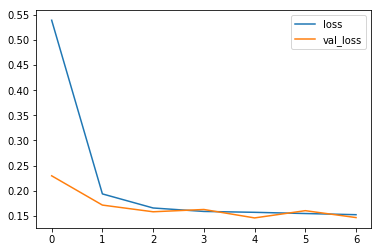

In [24]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [25]:
model.evaluate_generator(test_image_gen)

[0.15018840464534797, 0.94846153]

#### Make Prediction

In [26]:
pred = model.predict_generator(test_image_gen)
print(pred.shape)
predictions = pred > 0.5

(2600, 1)


In [27]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1300
           1       0.94      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [28]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1218,   82],
       [  54, 1246]], dtype=int64)

#### Make Prediction for a single image

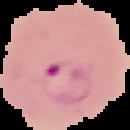

In [37]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
my_image = load_img(train_path+'\\parasitized'+'\\'+os.listdir(train_path+'\\parasitized')[0],target_size=image_shape)
my_image

In [38]:
type(my_image)

PIL.Image.Image

In [40]:
my_image = img_to_array(my_image)
print(type(my_image))

<class 'numpy.ndarray'>


In [41]:
#check shape of input image
print(my_image.shape)

(130, 130, 3)

In [44]:
#now add dimension for stating the btch size consists of 1 image only
my_image = np.expand_dims(my_image, 0)
print(my_image.shape)

(1, 130, 130, 3)


In [45]:
model.predict(my_image)

array([[0.]], dtype=float32)